In [5]:
########## Import Libararies
import os
import pickle
import glob
from tqdm.notebook import tqdm

import numpy as np
from skimage import measure
import scipy.ndimage
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

import open3d as o3d
from compas.geometry import trimesh_remesh
from compas.datastructures import Mesh
import nibabel as nib

# from util import *

import csv
import copy
import pickle
import random


In [4]:
random.seed(42) 
def sub_sort(folder_path):
    file_groups = {}
    
    for filename in os.listdir(folder_path):

        if filename.endswith('.nii.gz'):
            filename = filename[:-7] # .nii.gz elimination
        elif filename.endswith('.npy_L') or filename.endswith('.npy_R'):
            filename = filename[:-6] # .npy_L elimination
        elif filename.endswith('.nii.gz_R') or filename.endswith('.nii.gz_L'):
            filename = filename[:-9] # .npy_L elimination
        elif filename.endswith('_R') or filename.endswith('_L'):
            filename = filename[:-2] # .npy_L eliminations

        # print(filename)
        parts = filename.split('_')
        file_id = '_'.join(map(str, parts[:-5]))
        # print(file_id)
        days = (float(parts[-3]))
        
        # making group by id
        if file_id not in file_groups:
            file_groups[file_id] = []
        
        # filename & days as tuple
        file_groups[file_id].append((filename, days))

    # grouping with same id and sorting by days
    sorted_file_groups = []
    for file_id, files in file_groups.items():
        files_sorted = sorted(files, key=lambda x: x[1])  # x[1]이 days 값
        sorted_file_groups.append([file[0] for file in files_sorted])

    return sorted_file_groups

def get_sub_list(folder_path, ncad = 0):
    files = sub_sort(folder_path)
    file_list, age_list = [], []
    for file in files:
        f = file[0]
        split = f.split("\\")[-1].split("_")
        if not split[0].startswith("R"):
            ncad_flag = split[-2]
            age = split[2]
            if int(ncad_flag) == ncad:
                # print(f)
                npy_file = glob.glob(rf"{folder_path}\{f}*\*.npy")
                if npy_file!=[]:
                    loss = float(npy_file[0].split("_")[-1].split(".")[0])
                    # print(loss)
                    if loss <10:
                        if (ncad==0 and float(age)>59 and float(age)<90) or  (ncad==1 and float(age)>59 and float(age)<90) :
                            if ncad==0 and float(age)<73:
                                
                                if random.random()>0.7:
                            
                                    file_list.append(npy_file[0])
                                    age_list.append(float(age))
                            else:
                                file_list.append(npy_file[0])
                                age_list.append(float(age))
    # print(file_list)
    return file_list, age_list


import open3d as o3d
import csv
import glob
import numpy as np
import pickle
import os



tempdata = pickle.load(open(rf"D:\IdeaProjects\IITP_synth\lv-parametric-modelling\ipynb\NeuroImg_LVNET\cuttail_temp_L_tex.pkl","rb"))
lvmesh = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(tempdata['cuttail_vert']), triangles=o3d.utility.Vector3iVector(tempdata['lv']))

nc_list, nc_age_list = [], []

ad_list, ad_age_list = [], []
for dataset in ['oasis2', 'oasis3', 'adni', 'aibl']:
    folder = rf"D:\WJ\{dataset}_lv"
    nc, ncage = get_sub_list(folder)
    ad, adage = get_sub_list(folder, ncad = 1)
    nc_list += nc
    nc_age_list += ncage
    ad_list += ad
    ad_age_list += adage
nc_age_list = np.asarray(nc_age_list)
ad_age_list = np.asarray(ad_age_list)
print("NC: mean, std, min, max, sub# : ", np.mean(nc_age_list),np.std(nc_age_list),  np.min(ad_age_list), np.max(nc_age_list), np.shape(nc_age_list))
print("AD: mean, std, min, max, sub# : ", np.mean(ad_age_list),np.std(ad_age_list), np.min(ad_age_list), np.max(ad_age_list), np.shape(ad_age_list))

KeyError: 'lv'

In [ ]:
nc_list = glob.glob(rf"D:\IdeaProjects\IITP_synth\lv-parametric-modelling\ipynb\NeuroImg_LVNET\normal\*\sm*.npy")
ad_list = glob.glob(rf"D:\IdeaProjects\IITP_synth\lv-parametric-modelling\ipynb\NeuroImg_LVNET\demented\*\sm*.npy")
print(len(nc_list), len(ad_list))

184 180


# Generate Average Mesh

In [6]:
modes = ["0627"] #"manual_l", "manual_r","synthseg_l","synthseg_r","synthseg_l_new","synthseg_r_new","synthseg_l_new_2001","synthseg_r_new_2001"]
exclude_list = []

tempdata = pickle.load(open(rf"D:\IdeaProjects\IITP_synth\lv-parametric-modelling\ipynb\NeuroImg_LVNET\cuttail_temp_L_tex.pkl","rb"))
temp_mesh = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(tempdata['cuttail_vert']), triangles=o3d.utility.Vector3iVector(tempdata['cuttail_lv']))
# output_path = rf"D:\IdeaProjects\IITP_synth\lv-parametric-modelling\ipynb\edinburgh\edinburgh\0124\{mode}\out"
# filelist = glob.glob(rf"{l_save_path}\*.pkl")
# ######### Read Hippo Temp Mesh #########

temp_vert_num = np.asarray(temp_mesh.vertices).shape[0]


# temp_mesh.compute_vertex_normals()
# temp_mesh.paint_uniform_color([0.7, 1.0, 0.7])
count=0
# print(filelist)
index= 0
i_tag=0
filelist = nc_list + ad_list
new_verts = np.empty([len(filelist), temp_vert_num, 3])

for j, key in tqdm(enumerate(filelist)):
    sub = key.split("\\")[-1].split("_")[0]

    with open(key, 'rb') as f:
        Temp_saved = copy.deepcopy(temp_mesh)
        # pcd = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(points))
        try:
            # new_vert_file = glob.glob(rf"{output_path}\{sub}\5000*.npy")
            new_vert = np.load(f)[0]
            new_verts[index, :, :] = new_vert
            draw_mesh = copy.deepcopy(temp_mesh)
            draw_mesh.vertices = o3d.utility.Vector3dVector(new_vert)
            draw_mesh.compute_vertex_normals()
            draw_mesh.paint_uniform_color([0.7, 0.7, 1.0])
            index+=1
            # o3d.visualization.draw_geometries([draw_mesh,pcd], mesh_show_wireframe=True)
            # if index>10: break
        except:
            print(sub)

# print(count)
mean_vertices = np.mean(new_verts, axis=0)

avg_mesh = copy.deepcopy(temp_mesh)
if i_tag==0: avg_mesh.vertices = o3d.utility.Vector3dVector(mean_vertices)
mean_vertices =np.asarray(avg_mesh.vertices)
avg_mesh.compute_vertex_normals()
avg_mesh.paint_uniform_color([0.5, 0.5, 1.0])
o3d.visualization.draw_geometries([temp_mesh, avg_mesh], mesh_show_wireframe=True)

colors = np.empty((len(filelist), temp_vert_num, 3))
diffs = np.empty((len(filelist), temp_vert_num, 3))
for i in range(len(filelist)):#len(past_excel.keys())):
    sample = new_verts[i, :, :]
    diffs[i,:,:] =sample - mean_vertices
    # print(np.unique(diffs[i,:,:]))
    colors[i, :, 0] = np.linalg.norm(sample - mean_vertices, axis=1)
    colors[i, :, 1] = np.linalg.norm(sample - mean_vertices, axis=1)
    colors[i, :, 2] = np.linalg.norm(sample - mean_vertices, axis=1)
    # if colors[i, :, 0].mean()>10: print(i) 
var_color = np.var(colors, axis=0)/20


avg_mesh.vertex_colors = o3d.utility.Vector3dVector(var_color)

o3d.visualization.draw_geometries([avg_mesh], mesh_show_wireframe=True)
import matplotlib.pyplot as plt
import numpy as np

# Normalize your value (if not already between 0 and 1)
normalized_value = var_color[:,0]  # Example value, should be between 0 and 1
# print(np.var(colors))

# Get the viridis colormap
viridis = plt.cm.viridis

# Map the normalized value to a color
color = viridis(normalized_value) # Euclidean distance from mean
# print(color.shape)

avg_mesh.vertex_colors = o3d.utility.Vector3dVector(color[:,:3])

# if i_tag==0:o3d.io.write_triangle_mesh(rf"0124_deformity_result/fs-{mode}_avg.obj", avg_mesh)
o3d.visualization.draw_geometries([avg_mesh], mesh_show_wireframe=True)

import numpy as np

# For debugging purposes
# print(np.unique(diffs[0,:,:]))

avg_mesh_normals = np.asarray(avg_mesh.vertex_normals)
viridis = plt.cm.viridis
disps = np.empty((len(filelist), temp_vert_num))
for index, file in tqdm(enumerate(filelist)):
    sub_id = file.split("\\")[-1].split("_")[0]
    # print(colors[index,:,0], sub_id)
    dot_products = np.einsum('ij,ij->i', avg_mesh_normals, diffs[index])
    dot_products[dot_products<0] = -1
    dot_products[dot_products>=0] = 1
    disp = dot_products*colors[index,:,0] # signed Euclidean distance from mean
    #print(disp.shape)
    disps[index]=disp
np.save(f"ncad.npy", disps)
        



NameError: name 'nc_list' is not defined

In [7]:
nc_disps = np.load(f"ncad0.npy")
ad_disps = np.load(f"ncad1.npy")
nc_ad_disps = np.load(f"ncad.npy")
print(nc_disps.shape, ad_disps.shape, nc_ad_disps.shape)

(410, 2826) (182, 2826) (364, 2730)


In [10]:
print(nc_ad_disps.shape)

(364, 2730)


In [1]:
from scipy.stats import levene, bartlett, fligner, ttest_ind
from scipy.stats import mannwhitneyu
from scipy import stats
nc_num = 184

p_value = np.zeros(nc_ad_disps.shape[1])
for i in range(nc_ad_disps.shape[1]):
    data1 = nc_ad_disps[:180,i]
    data2 = nc_ad_disps[nc_num:nc_num+180,i]
    # print(data1.shape, data2.shape)
    stat_levene, p_levene = levene(data1, data2)
    # if p_levene<0.05:
    #     print(p_levene)
    stat, p = ttest_ind(data1, data2, alternative='two-sided')
    stat_fligner, p_fligner = fligner(data1, data2)
    # 1. 정규성 검정 (Shapiro-Wilk)
    _,shapiro1 = stats.shapiro(data1)
    _,shapiro2 = stats.shapiro(data2)

    # 2. 등분산성 검정 (Levene)
    _,levene_test = stats.levene(data1, data2) 
    p_value[i] = p_fligner
    # print(shapiro1,shapiro2,levene_test)
print("out")
viridis = plt.cm.hot
color = viridis(p_value*10)
avg_mesh.vertex_colors = o3d.utility.Vector3dVector(color[:,:3])
tri0 = np.asarray(avg_mesh.triangles)
tri = tri0.copy()
tri[:,[0,2]] = tri0[:,[2,0]]
avg_mesh.triangles = o3d.utility.Vector3iVector(tri)

o3d.io.write_triangle_mesh(rf"ncad_fligner_p_L_tex.obj", avg_mesh)
np.save(f"ncad_fligner_p_L_tex.npy", p_value)

o3d.visualization.draw_geometries([avg_mesh], mesh_show_wireframe=True)



The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


NameError: name 'np' is not defined

In [14]:


# index of mesh1_sdf<0.01
index1 = np.unique(tempdata['tri1'])
index2 = np.unique(tempdata['tri2'])
index3 = np.unique(tempdata['tri3'])
index4 = np.unique(tempdata['cuttail_hippo'])
lv = np.unique(tempdata['cuttail_lv'])
# N,3 size data to N*3 size data

print(index4)
print(index4.shape)
print(index1.shape, index1[:5])
tri1, tri2, tri3, tri4 = [], [], [], []
for i in range(tempdata['cuttail_lv'].shape[0]):

        if (tempdata['cuttail_lv'][i,0] in index1) and (tempdata['cuttail_lv'][i,1] in index1) and (tempdata['cuttail_lv'][i,2] in index1):
            tri1.append(tempdata['cuttail_lv'][i].tolist())
        elif (tempdata['cuttail_lv'][i,0] in index2) and (tempdata['cuttail_lv'][i,1] in index2) and (tempdata['cuttail_lv'][i,2] in index2):
            tri2.append(tempdata['cuttail_lv'][i].tolist())
        elif (tempdata['cuttail_lv'][i,0] in index3) and (tempdata['cuttail_lv'][i,1] in index3) and (tempdata['cuttail_lv'][i,2] in index3):
            tri3.append(tempdata['cuttail_lv'][i].tolist())
        elif (tempdata['cuttail_lv'][i,0] in index4) and (tempdata['cuttail_lv'][i,1] in index4) and (tempdata['cuttail_lv'][i,2] in index4):
            tri4.append(tempdata['cuttail_lv'][i].tolist())
tri1 = np.asarray((tri1))
print(tri1.shape)
tri2 = np.asarray((tri2))
print(tri2.shape)
tri3 = np.asarray((tri3))
print(tri3.shape)
tri4 = np.asarray((tri4))
print(tri4.shape)

for tri in [tri1, tri2, tri3, tri4]:
    tri0 = np.copy(tri)
    tri[:,[0,2]] = tri0[:,[2,0]]
mesh1 = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(tempdata['cuttail_vert']), triangles=o3d.utility.Vector3iVector(tri1))
mesh2 = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(tempdata['cuttail_vert']), triangles=o3d.utility.Vector3iVector(tri2))
mesh3 = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(tempdata['cuttail_vert']), triangles=o3d.utility.Vector3iVector(tri3))
mesh4 = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(tempdata['cuttail_vert']), triangles=o3d.utility.Vector3iVector(tri4))
mesh5 = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(tempdata['cuttail_vert']), triangles=o3d.utility.Vector3iVector(tempdata['cuttail_lv']))
mesh1.paint_uniform_color([1.0, 0.7, 0.7])
mesh2.paint_uniform_color([0.7, 1.0, 0.7])
mesh3.paint_uniform_color([0.7, 0.7, 1.0])
mesh4.paint_uniform_color([0.7, 0.85, 0.8])
        
o3d.visualization.draw_geometries([mesh1,mesh2,mesh3,mesh4,mesh5], mesh_show_wireframe=True)

[ 334  340  341  366  367  368  369  372  420  421  422  426  428  438
  439  440  441  443  444  445  446  447  449  454  876  878  937  944
  945  947  953  958  959  966  967  969  983  996 1014 2354 2361 2435
 2436 2437 2438 2439 2440 2441 2442 2443 2444 2445 2446 2447 2448 2449
 2450 2451 2452 2453 2454 2455 2456 2457 2458 2459 2460 2461 2462 2463
 2464 2465 2466 2467 2468 2469 2470 2471 2472 2473 2474 2475 2476 2477
 2478 2479 2480 2481 2482 2483 2484 2485 2486 2487 2488 2489 2490 2491
 2492 2493 2494 2495 2496 2497 2498 2499 2500 2501 2502 2503 2504 2505
 2506 2507 2508 2509 2510 2511 2512 2513 2514 2515 2516 2517 2518 2519
 2520 2521 2522 2523 2524 2525 2526 2527 2528 2529 2530 2531 2532 2533
 2534 2535 2536 2537 2538 2539 2540 2541 2542 2543 2544 2545 2546 2547
 2548 2549 2550 2551 2552 2553 2554 2555 2556 2557 2558 2559 2560 2561
 2562 2563 2564 2565 2566 2567 2568 2569 2570 2571 2572 2573 2574 2575
 2576 2577 2578 2579 2580 2581 2582 2583 2584 2585 2586 2587 2588 2589
 2590 

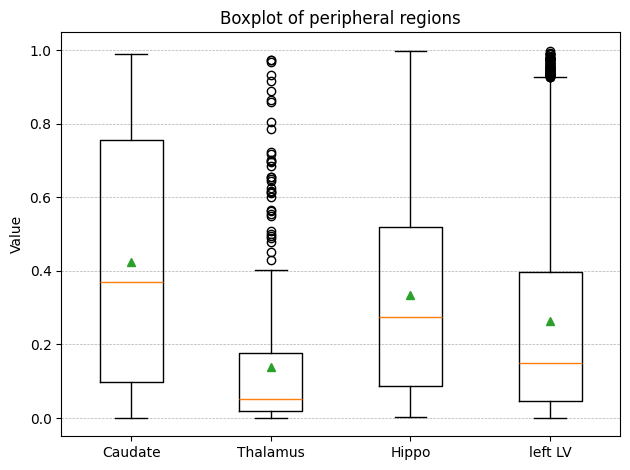

In [26]:
p_all = []


for index in [index1, index2, index4]: # caudate, thalamus, opposite LV
    
    p_all.append(p_value[index])
p_all.append(p_value)
plt.boxplot(
    p_all,
    vert=True,              # vertical boxes (set False for horizontal)
    labels=['Caudate', 'Thalamus', 'Hippo', 'left LV'],
    showmeans=True          # draws a green triangle at the mean
)

plt.ylabel("Value")
plt.title("Boxplot of peripheral regions")
plt.grid(axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()